# Market Basket Analysis (MBA) or Association Rule Mining
# Groceries Recommendation

In [1]:
# Importing warnings and libraries

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc = {'axes.facecolor':'#f2f2f2', 'figure.facecolor':'#ffffff'})

from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import time

## Data Preparation, EDA & Data Visualization

In [2]:
# Loading the dataset 'Groceries data'

Groceries_data = pd.read_csv('Groceries data.csv')
Groceries_data.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


In [3]:
# Observing the information of the dataset

Groceries_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


In [4]:
# Creating a copy of the dataset

groceries = Groceries_data.copy()

In [5]:
# Checking missing values for the dataset 'groceries'

print('There are a total of ' + (str(groceries.isna().sum().sum()) + ' missing values in the dataset.'))

There are a total of 0 missing values in the dataset.


In [6]:
# Converting the 'Date' column to datetime dtype

groceries['Date'] = pd.to_datetime(groceries['Date'], infer_datetime_format = True)
groceries['Date']

0       2015-07-21
1       2015-05-01
2       2015-09-19
3       2015-12-12
4       2015-01-02
           ...    
38760   2014-08-10
38761   2014-02-23
38762   2014-04-16
38763   2014-03-12
38764   2014-12-26
Name: Date, Length: 38765, dtype: datetime64[ns]

In [7]:
# Checking the statistics of 'groceries'
# 5-summary statistics

groceries.describe()

,Member_number,year,month,day,day_of_week
count,38765.000000,38765.000000,38765.000000,38765.000000,38765.000000
mean,3003.641868,2014.528518,6.477570,15.753231,3.014498
std,1153.611031,0.499193,3.431561,8.801391,1.987669
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2002.000000,2014.000000,4.000000,8.000000,1.000000
50%,3005.000000,2015.000000,6.000000,16.000000,3.000000
75%,4007.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


In [8]:
# Checking the statistics of 'groceries'
# Checking the statistics of categorical colum 'item'

groceries.describe(include = object)

,itemDescription
count,38765
unique,167
top,whole milk
freq,2502


In [9]:
# Checking the statistics of 'groceries'
# Getting the 'month', 'day' and 'day_of_week' with more item sales

groceries[['month', 'day', 'day_of_week']].mode()

,month,day,day_of_week
0,8,28,3


In [10]:
# Renaming some columns, in order to keep the same pattern in all of them

groceries.rename(columns = {'Member_number': 'member_id', 'Date': 'date', 'itemDescription': 'item'}, inplace = True)

In [11]:
# Sorting the 'groceries' dataset by 'Date'

groceries = groceries.sort_values(by = ['date', 'member_id'], ascending = [True, True])
groceries

,member_id,date,item,year,month,day,day_of_week
10065,1249,2014-01-01,citrus fruit,2014,1,1,2
26214,1249,2014-01-01,coffee,2014,1,1,2
15338,1381,2014-01-01,curd,2014,1,1,2
31487,1381,2014-01-01,soda,2014,1,1,2
11134,1440,2014-01-01,other vegetables,2014,1,1,2
...,...,...,...,...,...,...,...
17777,4058,2015-12-30,cream cheese,2015,12,30,2
557,4565,2015-12-30,canned beer,2015,12,30,2
16706,4565,2015-12-30,canned beer,2015,12,30,2
1134,4863,2015-12-30,dessert,2015,12,30,2


#### Who are the loyal customers?

In [12]:
# Displaying the customers with most number of items bought

orders = groceries.groupby(by = 'member_id', as_index = False)['item'].count()
print('\n\033[1m The TOP 5 customers with the highets number of orders are: \033[0m')
orders.sort_values(by = 'item', ascending = False).head()


 The TOP 5 customers with the highets number of orders are: 


,member_id,item
2120,3180,36
2665,3737,33
1994,3050,33
1026,2051,33
2838,3915,31


#### What is the distribution of items sold per month?

In [13]:
# Creating a new column 'year_month'

groceries.insert(loc = 4, column = 'year_month', value = groceries['date'].dt.to_period('M').dt.to_timestamp())
groceries

,member_id,date,item,year,year_month,month,day,day_of_week
10065,1249,2014-01-01,citrus fruit,2014,2014-01-01,1,1,2
26214,1249,2014-01-01,coffee,2014,2014-01-01,1,1,2
15338,1381,2014-01-01,curd,2014,2014-01-01,1,1,2
31487,1381,2014-01-01,soda,2014,2014-01-01,1,1,2
11134,1440,2014-01-01,other vegetables,2014,2014-01-01,1,1,2
...,...,...,...,...,...,...,...,...
17777,4058,2015-12-30,cream cheese,2015,2015-12-01,12,30,2
557,4565,2015-12-30,canned beer,2015,2015-12-01,12,30,2
16706,4565,2015-12-30,canned beer,2015,2015-12-01,12,30,2
1134,4863,2015-12-30,dessert,2015,2015-12-01,12,30,2


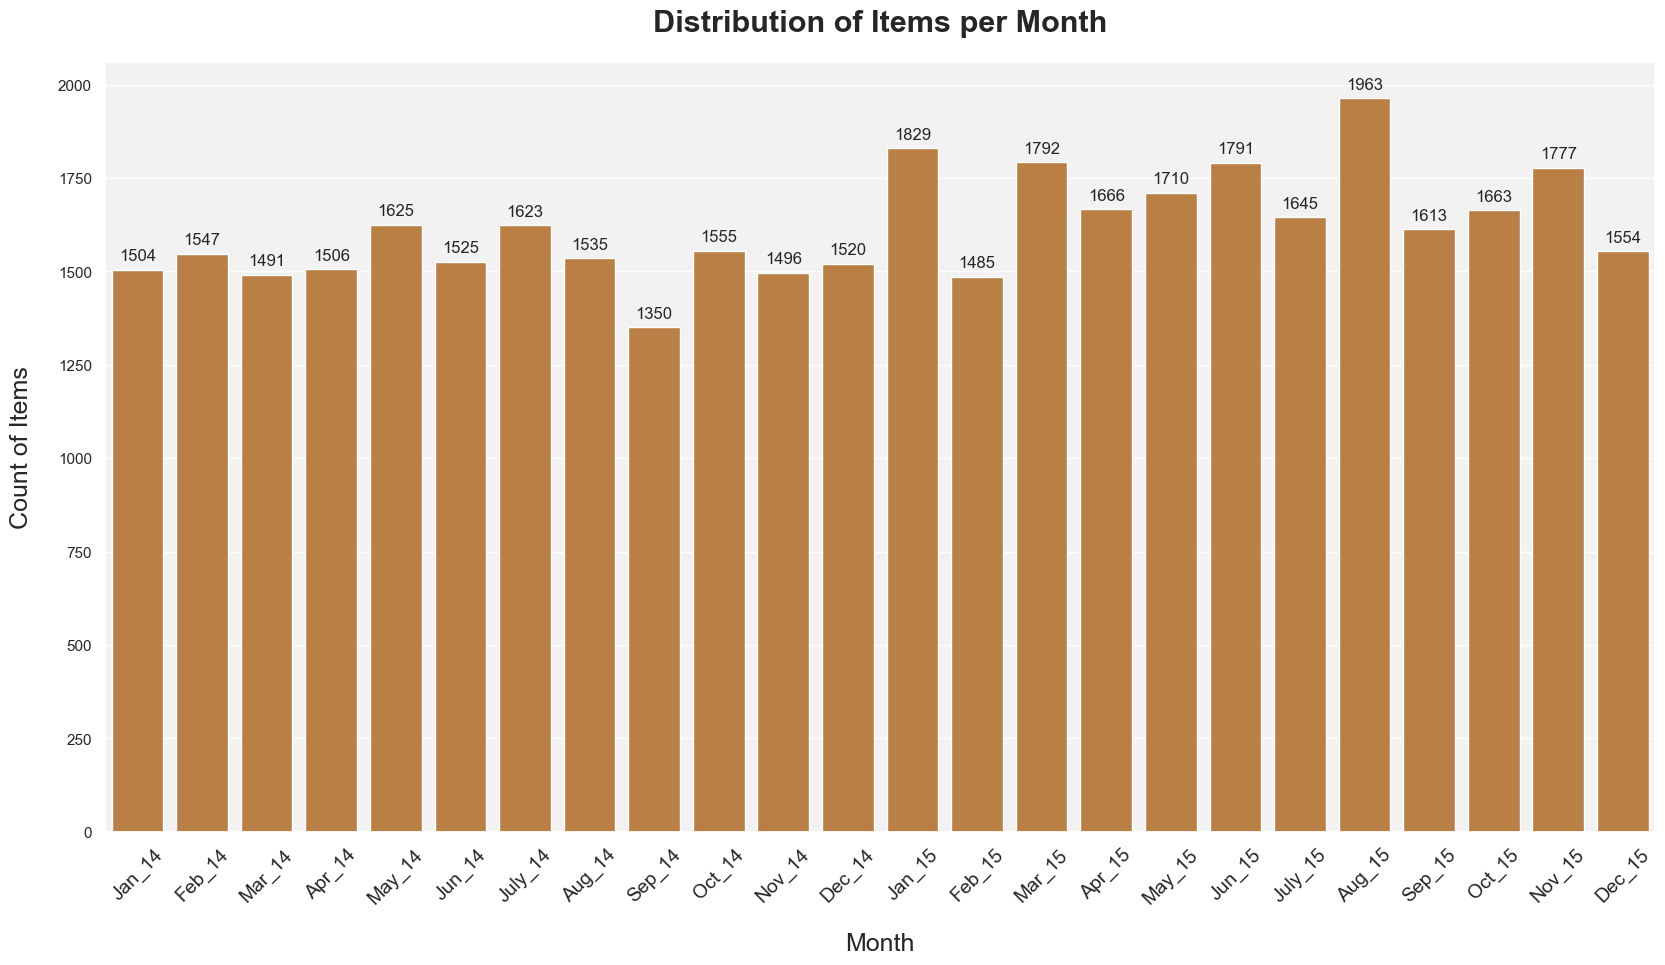

In [14]:
# Plotting the distribution of items per 'year_month'

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data = groceries, x = groceries['year_month'], color = '#CD7F32')

# Adding the bars' labels
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

plt.title('Distribution of Items per Month', fontsize = 22, fontweight = 'bold', pad = 22)
plt.xlabel('Month', fontsize = 18, labelpad = 18)
plt.ylabel('Count of Items', fontsize = 18, labelpad = 18)
ax.set_xticklabels(('Jan_14','Feb_14','Mar_14','Apr_14','May_14','Jun_14','July_14','Aug_14','Sep_14','Oct_14','Nov_14','Dec_14',
                    'Jan_15','Feb_15','Mar_15','Apr_15','May_15','Jun_15','July_15','Aug_15','Sep_15','Oct_15','Nov_15','Dec_15'),
                   rotation = 45, fontsize = 14);      

#### What is the distribution of items sold per day of the week?

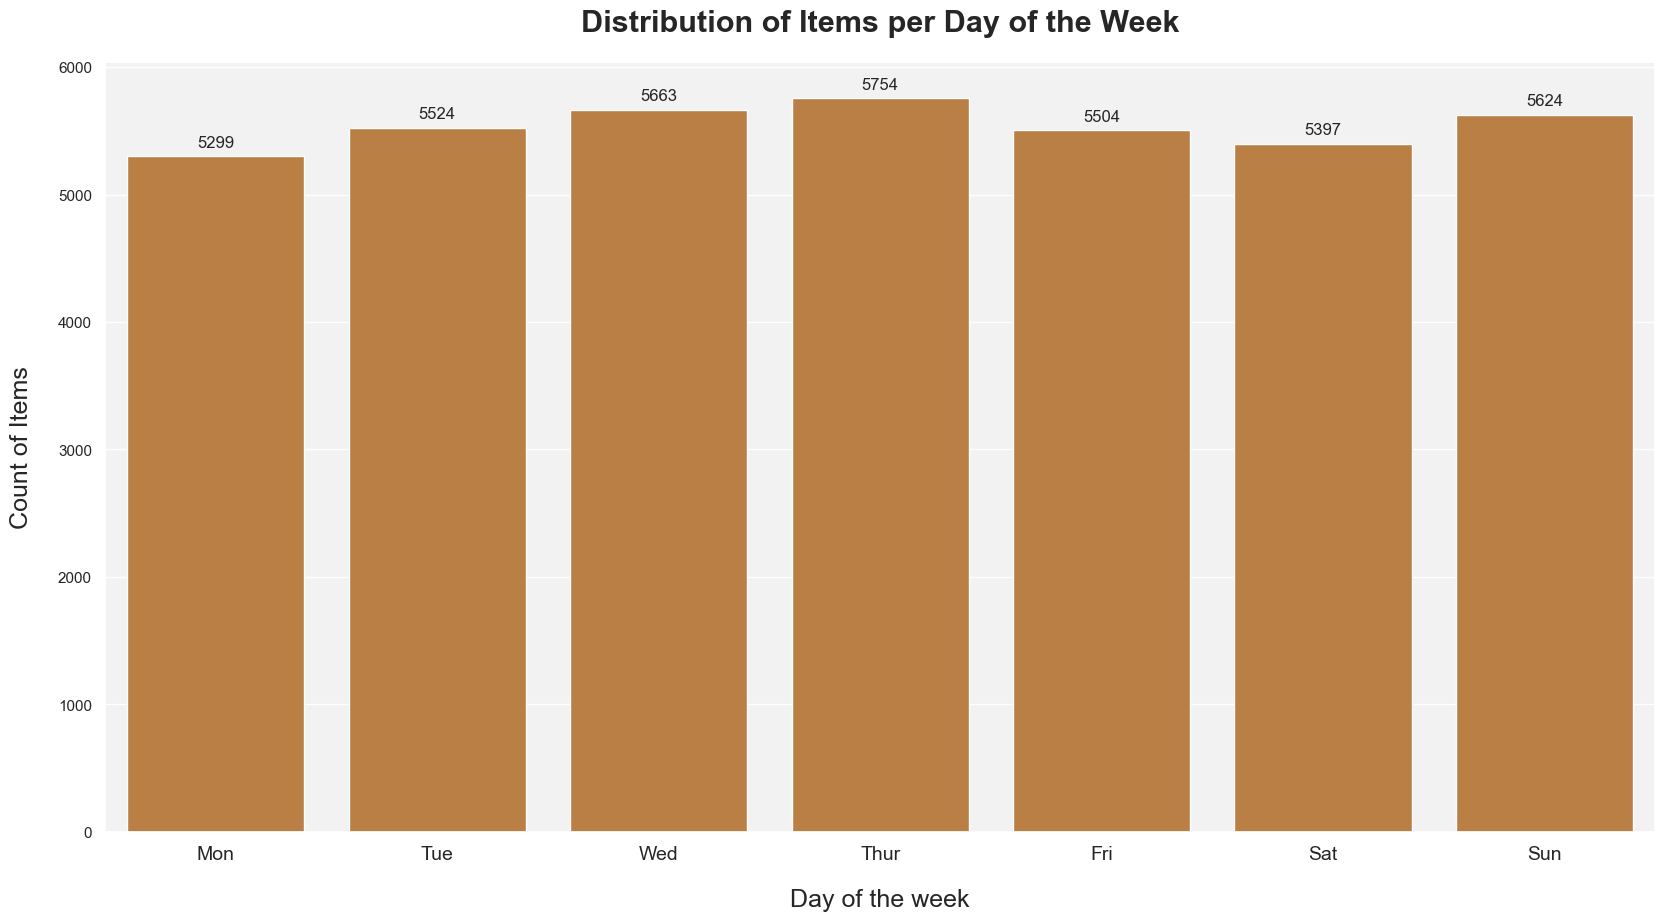

In [15]:
# Plotting the distribution of items per 'day_of_week'

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data = groceries, x = groceries['day_of_week'].sort_index(), color = '#CD7F32')

# Adding the bars' labels
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

plt.title('Distribution of Items per Day of the Week', fontsize = 22, fontweight = 'bold', pad = 22)
plt.xlabel('Day of the week', fontsize = 18, labelpad = 18)
plt.ylabel('Count of Items', fontsize = 18, labelpad = 18)
ax.set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'), fontsize = 14);

#### What are the 10 most sold items?

In [16]:
# Total of unique items

print('There are a total of ' + (str(groceries['item'].nunique()) + ' unique items in the dataset.'))

There are a total of 167 unique items in the dataset.


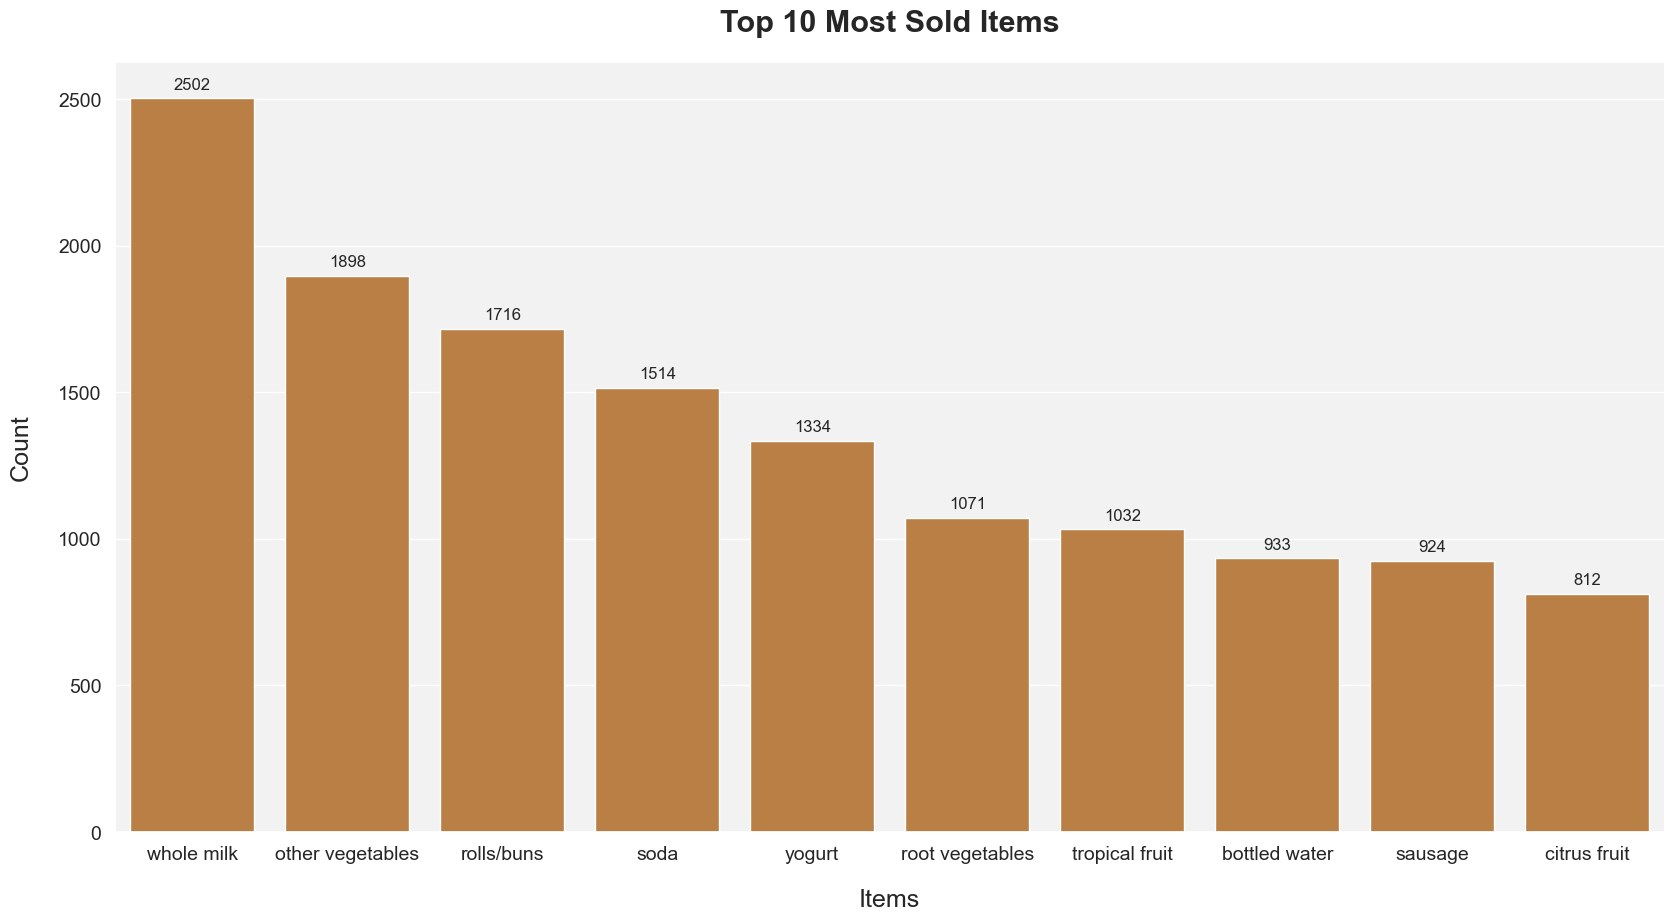

In [17]:
# Plotting the top 10 most sold items

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.countplot(data = groceries, x = groceries['item'], order = groceries['item'].value_counts(
    ascending = False).head(10).index, color = '#CD7F32')

# Adding the bars' labels
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center',
                xytext = (0, 10), textcoords = 'offset points')

plt.title('Top 10 Most Sold Items', fontsize = 22, fontweight = 'bold', pad = 22)
plt.xlabel('Items', fontsize = 18, labelpad = 18)
plt.ylabel('Count', fontsize = 18, labelpad = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

#### What is the average of 'items' bought per 'member_id'?

In [18]:
# Creating a new dataframe to analyse the average of 'items' bought per 'member_id'

items_avg = groceries[['date', 'member_id', 'item']]
items_avg['count'] = 1
items_avg

,date,member_id,item,count
10065,2014-01-01,1249,citrus fruit,1
26214,2014-01-01,1249,coffee,1
15338,2014-01-01,1381,curd,1
31487,2014-01-01,1381,soda,1
11134,2014-01-01,1440,other vegetables,1
...,...,...,...,...
17777,2015-12-30,4058,cream cheese,1
557,2015-12-30,4565,canned beer,1
16706,2015-12-30,4565,canned beer,1
1134,2015-12-30,4863,dessert,1


In [19]:
# Grouping transactions by 'member_id' and 'date', adding the items bought and obtaining the overall mean

print('The average of items bought per transaction is ' + str(round(items_avg.groupby(
    ['date', 'member_id'])['count'].sum().mean(), 2)) +'.')

The average of items bought per transaction is 2.59.


## Executing the Market Basket Analysis (MBA)

In [20]:
# Creating the basket

groceries_basket = (groceries.groupby(['member_id', 'item'])['item'].count().unstack().reset_index().fillna(0).set_index(
    'member_id'))
groceries_basket

item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
member_id,,,,,,,,,,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Encoding the basket item count

def encode_units(x):
    if x < 1:
        return 0
    if x >= 1:
        return 1
    
groceries_basket = groceries_basket.applymap(encode_units)
groceries_basket

item,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
member_id,,,,,,,,,,,,,,,,,,,,,
1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1001,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,1,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Apriori algorithm

In [22]:
# Creating the itemsets frequent list with support 0.05

itemsets_frequent_a = apriori(groceries_basket.astype('bool'), min_support = 0.05, use_colnames = True)
itemsets_frequent_a.sort_values(by = 'support', ascending = False)

,support,itemsets
55,0.458184,(whole milk)
37,0.376603,(other vegetables)
41,0.349666,(rolls/buns)
47,0.313494,(soda)
56,0.282966,(yogurt)
...,...,...
160,0.050539,"(other vegetables, tropical fruit, whole milk)"
158,0.050282,"(other vegetables, whole milk, sausage)"
101,0.050026,"(other vegetables, margarine)"
88,0.050026,"(curd, rolls/buns)"


In [23]:
# Storing association rules

a_rules = association_rules(itemsets_frequent_a, metric = 'lift', min_threshold = 1)

# Sorting the association by lift and support

a_rules[(a_rules['lift'] > 1) & (a_rules['confidence'] >= 0.5)
       ].sort_values(['lift', 'support'], ascending = False).reset_index(drop = True).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(bottled water, whole milk)",(other vegetables),0.112365,0.376603,0.056183,0.500000,1.327657,0.013865,1.246793
1,"(bottled water, other vegetables)",(whole milk),0.093894,0.458184,0.056183,0.598361,1.305941,0.013162,1.349012
2,"(other vegetables, yogurt)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003,0.016704,1.344507
3,"(rolls/buns, yogurt)",(whole milk),0.111339,0.458184,0.065931,0.592166,1.292420,0.014917,1.328521
4,"(rolls/buns, other vegetables)",(whole milk),0.146742,0.458184,0.082093,0.559441,1.220996,0.014859,1.229837
5,"(soda, yogurt)",(whole milk),0.097486,0.458184,0.054387,0.557895,1.217622,0.009720,1.225537
6,"(other vegetables, soda)",(whole milk),0.124166,0.458184,0.069266,0.557851,1.217528,0.012375,1.225416
7,"(other vegetables, tropical fruit)",(whole milk),0.091329,0.458184,0.050539,0.553371,1.207749,0.008693,1.213123
8,"(rolls/buns, soda)",(whole milk),0.119805,0.458184,0.065162,0.543897,1.187072,0.010269,1.187926
9,(shopping bags),(whole milk),0.168291,0.458184,0.091329,0.542683,1.184422,0.014220,1.184772


In [24]:
# Creating a function to apply market basket analysis to unique items

def bought_together_frequently_a(item):  
    
    # Dataframe of item passed
    df_item = groceries_basket[groceries_basket[item] == 1]

    # Apriori algorithm
    itemsets_frequent_a = apriori(df_item.astype('bool'), min_support = 0.05, use_colnames = True)

    # Storing association rules
    rules_a = association_rules(itemsets_frequent_a, metric = 'lift', min_threshold = 1)

    # Sorting the association by lift and support
    rules_a[(rules_a['lift'] > 1) & (rules_a['confidence'] >= 0.5)].sort_values(['lift', 'support'], 
                                                                                 ascending = False).reset_index(drop = True)

    # Returning top 3 items with highest lift and support
    print('Items frequently bought together with {0}:'.format(item))
    print()
    return print(rules_a['consequents'].head(5))

In [25]:
# Applying the function apriori to a specific item

bought_together_frequently_a('whole milk')

Items frequently bought together with whole milk:

0          (whole milk)
1            (UHT-milk)
2                (beef)
3    (other vegetables)
4                (soda)
Name: consequents, dtype: object


### FP Growth algorithm

In [26]:
# Creating the itemsets frequent list with support 0.05

itemsets_frequent_fp = fpgrowth(groceries_basket.astype('bool'), min_support = 0.05, use_colnames = True)
itemsets_frequent_fp.sort_values(by = 'support', ascending = False)

,support,itemsets
0,0.458184,(whole milk)
15,0.376603,(other vegetables)
9,0.349666,(rolls/buns)
1,0.313494,(soda)
2,0.282966,(yogurt)
...,...,...
110,0.050539,"(other vegetables, tropical fruit, whole milk)"
78,0.050282,"(other vegetables, whole milk, sausage)"
131,0.050026,"(other vegetables, margarine)"
100,0.050026,"(curd, rolls/buns)"


In [27]:
# Storing association rules

rules_fp = association_rules(itemsets_frequent_fp, metric = 'lift', min_threshold = 1)

# Sorting the association by lift and support

rules_fp[(rules_fp['lift'] > 1) & (rules_fp['confidence'] >= 0.5)
        ].sort_values(['lift', 'support'], ascending = False).reset_index(drop = True).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(bottled water, whole milk)",(other vegetables),0.112365,0.376603,0.056183,0.500000,1.327657,0.013865,1.246793
1,"(bottled water, other vegetables)",(whole milk),0.093894,0.458184,0.056183,0.598361,1.305941,0.013162,1.349012
2,"(other vegetables, yogurt)",(whole milk),0.120318,0.458184,0.071832,0.597015,1.303003,0.016704,1.344507
3,"(rolls/buns, yogurt)",(whole milk),0.111339,0.458184,0.065931,0.592166,1.292420,0.014917,1.328521
4,"(rolls/buns, other vegetables)",(whole milk),0.146742,0.458184,0.082093,0.559441,1.220996,0.014859,1.229837
5,"(soda, yogurt)",(whole milk),0.097486,0.458184,0.054387,0.557895,1.217622,0.009720,1.225537
6,"(other vegetables, soda)",(whole milk),0.124166,0.458184,0.069266,0.557851,1.217528,0.012375,1.225416
7,"(other vegetables, tropical fruit)",(whole milk),0.091329,0.458184,0.050539,0.553371,1.207749,0.008693,1.213123
8,"(rolls/buns, soda)",(whole milk),0.119805,0.458184,0.065162,0.543897,1.187072,0.010269,1.187926
9,(shopping bags),(whole milk),0.168291,0.458184,0.091329,0.542683,1.184422,0.014220,1.184772


In [28]:
# Creating a function to apply market basket analysis to unique items

def bought_together_frequently_fp(item):  
    
    # Dataframe of item passed
    df_item = groceries_basket[groceries_basket[item] == 1]

    # Apriori algorithm
    itemsets_frequent_fp = apriori(df_item.astype('bool'), min_support = 0.05, use_colnames = True)

    # Storing association rules
    rules_fp = association_rules(itemsets_frequent_fp, metric = 'lift', min_threshold = 1)

    # Sorting the association by lift and support
    rules_fp[(rules_fp['lift'] > 1) & (rules_fp['confidence'] >= 0.5)].sort_values(['lift', 'support'], 
                                                                                 ascending = False).reset_index(drop = True)

    # Returning top 3 items with highest lift and support
    print('Items frequently bought together with {0}:'.format(item))
    print()
    return print(rules_fp['consequents'].head(5))

In [29]:
# Applying the function fp growth to a specific item

bought_together_frequently_fp('whole milk')

Items frequently bought together with whole milk:

0          (whole milk)
1            (UHT-milk)
2                (beef)
3    (other vegetables)
4                (soda)
Name: consequents, dtype: object


In [30]:
# Calculating run time for apriori

warnings.filterwarnings('ignore')

l = [0.01, 0.02, 0.03, 0.04, 0.05]
t_ap = []

for i in l:
    t1 = time.time()
    apriori(groceries_basket, min_support = i, use_colnames = True)
    
    t2 = time.time()
    t_ap.append((t2 - t1) * 1000)

In [31]:
# Calculating run time for fp growth

warnings.filterwarnings('ignore')

l = [0.01, 0.02, 0.03, 0.04, 0.05]
t_fp = []

for i in l:
    t1 = time.time()
    fpgrowth(groceries_basket, min_support = i, use_colnames = True)
    
    t2 = time.time()
    t_fp.append((t2 - t1) * 1000)

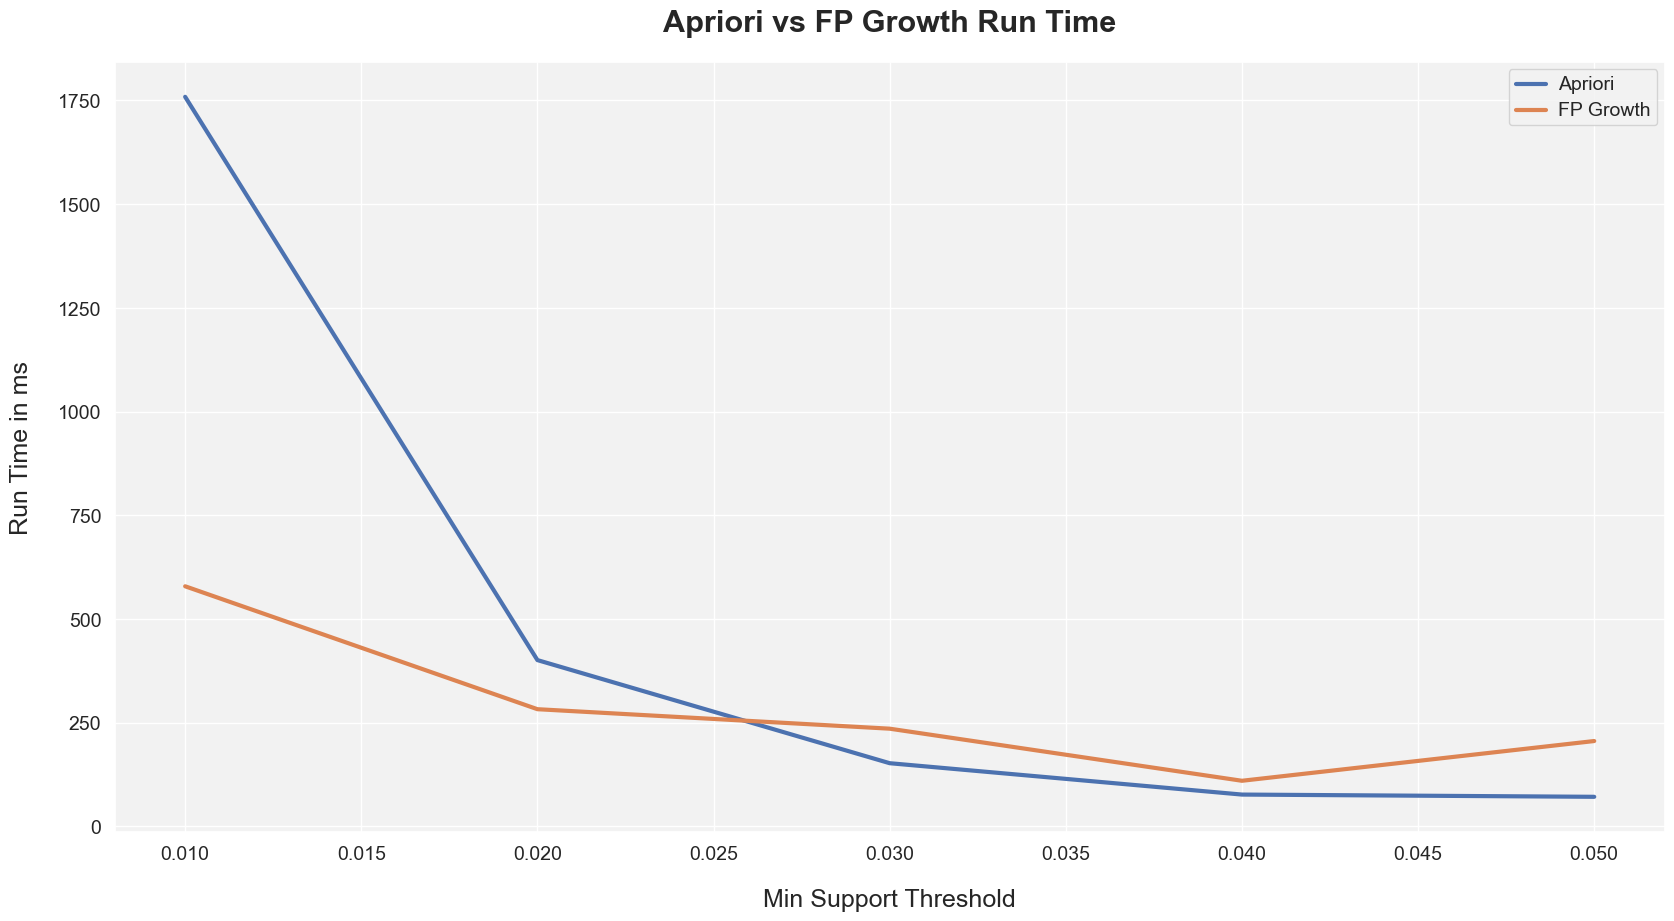

In [32]:
# Comparing time run of apriori and fp growth

fig = plt.gcf()
fig.set_size_inches(20, 10)

ax = sns.lineplot(x = l, y = t_ap, label = 'Apriori', linewidth = 3)
ax = sns.lineplot(x = l, y = t_fp, label = 'FP Growth', linewidth = 3)

plt.title('Apriori vs FP Growth Run Time', fontsize = 22, fontweight = 'bold', pad = 22)
plt.xlabel('Min Support Threshold', fontsize = 18, labelpad = 18)
plt.ylabel('Run Time in ms', fontsize = 18, labelpad = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.setp(ax.get_legend().get_texts(), fontsize = 14);